# 使用 Keras 進行花朵辨識
本範例輸出期末考的 CNN baseline 預測, 提供同學參考

In [1]:
import tensorflow as tf
import numpy as np
import os

C:\Python\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 先來看看訓練資料下有那些目錄吧
import os
train_path = '../input/train/'
test_path = '../input/test/'
print(os.listdir(train_path))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


# 1. 載入套件

In [3]:
# 載入基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 繪圖設定
from matplotlib import style
%matplotlib inline  
style.use('fivethirtyeight')

# 設定忽略警告訊息
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 載入 Keras 預處理套件 - ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# 載入 Keras 其他深度學習套件
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical # Keras 做 One Hot Encoding 的函數
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.applications.resnet50 import ResNet50, preprocess_input

Using TensorFlow backend.


In [5]:
# 其他相關套件    
import tensorflow as tf
import random as rn
import cv2 
import glob
from PIL import Image
from tqdm import tqdm # 進度條顯示套件  

# 2. 資料預處理

In [6]:
# 設定執行參數
IMAGE_SIZE = (240, 320)
BATCH_SIZE = 16 # 設 32 效果會更好, 但同學要依照 GPU上的記憶體量力而為, 如果跑不動可以降到 8 或更低

# 設定花朵名稱對應的類別碼
flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}
flowers = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [7]:
# 設定 ImageDataGenerator
datagen = ImageDataGenerator(    
    rotation_range=10, #隨機旋轉角度的上限 (角度值 : 0 ~ 180)
    width_shift_range=0.2, # 左右隨機平移上限
    height_shift_range=0.2, # 上下隨機平移上限
    shear_range=0.2, # 逆時針的剪切變形角度
    zoom_range=0.2, # 影像倍率放大縮小的上限
    horizontal_flip=True, # 是否左右翻轉
    fill_mode='nearest', # 填補周圍空缺方法
    validation_split=0.2) # 測試集採樣比

In [8]:
# 設定輸入的 train / test 資料流
train_generator = datagen.flow_from_directory(train_path, target_size=(240, 320), classes=flowers, 
                                                    batch_size=BATCH_SIZE, subset='training') # 設為訓練集
valid_generator = datagen.flow_from_directory(train_path, target_size=(240, 320), classes=flowers, 
                                                    batch_size=BATCH_SIZE, subset='validation') # 設為驗證集         

Found 2260 images belonging to 5 classes.
Found 563 images belonging to 5 classes.


# 3. 設定模型與運算

#### 使用 Keras 定義一個 Resnet 模型
resnet = ResNet50(input_shape=(240, 320, 3), weights='imagenet', pooling='avg', include_top=False)
output = keras.layers.Dense(5, activation="softmax")(resnet.output)
model = Model(inputs=[resnet.input], outputs=[output])

In [10]:
# 顯示模型形狀
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 120, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 120, 160, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

res3a_branch2a (Conv2D)         (None, 30, 40, 128)  32896       activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 30, 40, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 30, 40, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 30, 40, 128)  147584      activation_11[0][0]              
__________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizati (None, 30, 40, 128)  512         res3a_branch2b[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
add_7 (Add)                     (None, 30, 40, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 30, 40, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 15, 20, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 15, 20, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_33 (Activation)      (None, 15, 20, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 15, 20, 1024) 263168      activation_33[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 15, 20, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_11 (Add)                    (None, 15, 20, 1024) 0           bn4d_branch2c[0][0]              
                                                                 activation_31[0][0]              
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_44 (Activation)      (None, 8, 10, 512)   0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 8, 10, 512)   2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 8, 10, 512)   2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 8, 10, 512)   0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 8, 10, 2048)  1050624     activation_45[0][0]              
__________

In [11]:
# 設定模型收斂方式並編譯模型
model.compile(optimizer=keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['acc'])

In [12]:
# 設定 early stop (若 valid accuracy 沒有更好就提早停下) 與 call back (紀錄最好一次的模型參數)
early_stopping = EarlyStopping(monitor='val_acc', patience=30)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, save_weights_only=True)

In [13]:
# 執行, 並將結果儲存於 history 物件中
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.samples // BATCH_SIZE,                              
                              validation_data=valid_generator, validation_steps=valid_generator.samples // BATCH_SIZE,
                              use_multiprocessing=False, verbose=2, epochs=100,
                              workers=8, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
 - 57s - loss: 0.9767 - acc: 0.6543 - val_loss: 0.4544 - val_acc: 0.8579
Epoch 2/100
 - 44s - loss: 0.4551 - acc: 0.8568 - val_loss: 0.3214 - val_acc: 0.8810
Epoch 3/100
 - 44s - loss: 0.3192 - acc: 0.9051 - val_loss: 0.2559 - val_acc: 0.9201
Epoch 4/100
 - 44s - loss: 0.2427 - acc: 0.9251 - val_loss: 0.2430 - val_acc: 0.9183
Epoch 5/100
 - 44s - loss: 0.2165 - acc: 0.9344 - val_loss: 0.2119 - val_acc: 0.9272
Epoch 6/100
 - 44s - loss: 0.1693 - acc: 0.9464 - val_loss: 0.2351 - val_acc: 0.9201
Epoch 7/100
 - 44s - loss: 0.1378 - acc: 0.9610 - val_loss: 0.2163 - val_acc: 0.9272
Epoch 8/100
 - 44s - loss: 0.1094 - acc: 0.9712 - val_loss: 0.2032 - val_acc: 0.9361
Epoch 9/100
 - 44s - loss: 0.0876 - acc: 0.9756 - val_loss: 0.2161 - val_acc: 0.9343
Epoch 10/100
 - 44s - loss: 0.0804 - acc: 0.9783 - val_loss: 0.2199 - val_acc: 0.9343
Epoch 11/100
 - 44s - loss: 0.0652 - acc: 0.9809 - val_loss: 0.2137 - val_acc: 0.9325
Epoch 12/100
 - 44s - loss: 0.0633 - acc: 0.9827 - val_loss: 0.

In [14]:
# 重新載回最好一次的模型參數
best_model = model.load_weights("best_model.h5")

# 4. 訓練結果影像化, 並輸出預測

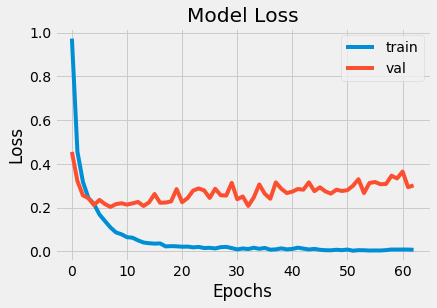

In [15]:
# 顯示訓練集的 Loss 結果
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

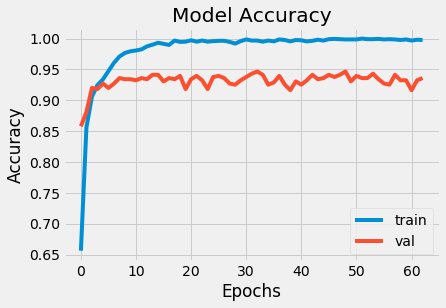

In [16]:
# 顯示訓練集的 Accuracy 結果
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [17]:
# 設定最後的輸出資料
X_test = list()
id_test = []

In [18]:
# 使用 Keras 內建的載入寫法 
def load_image(img_path):
    img = image.load_img(img_path, target_size=(240, 320))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img 
def make_test_data():
    global X_test
    dir_path = test_path
    for img in tqdm(os.listdir(dir_path)):
        id_test.append(img[:-4])
        path = os.path.join(dir_path, img)
        img = load_image(path)
        img = np.squeeze(img, axis=0)
        X_test.append(np.array(img))
make_test_data()        
X_test = np.array(X_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 361.72it/s]


In [19]:
# 輸出預測檔
pred = model.predict(X_test)
pred_digits = np.argmax(pred, axis=1)
sub = pd.DataFrame({'id': id_test, 'flower_class': pred_digits})
sub.to_csv('flower_Pretrain.csv', index = False)